In [1]:
%pylab inline
import seaborn as sns
import pandas as pd
import time
import scipy
import tqdm
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set_style('white')
pd.set_option('display.max_columns', 35)
plt.rcParams['figure.figsize']=(12,8)
%config InlineBackend.figure_format='retina'

# Reading In Data

In [3]:
print "Starting to read in data..."

t1 = time.time()
requests = pd.read_csv('311__Service_Requests.csv')
t2 = time.time()

print "Read in data in %.2f seconds." % (t2 - t1)

Starting to read in data...
Read in data in 6.97 seconds.


//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (13,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# processing on the data types
print "Starting to process data types..."
t1 = time.time()

# converting to datetimes
for col in ['OPEN_DT', 'TARGET_DT', 'CLOSED_DT']:
    requests[col] = pd.to_datetime(requests[col], infer_datetime_format=True)

# derived columns
requests['ACTUAL_LAG'] = requests['CLOSED_DT'] - requests['OPEN_DT']
requests['EXPECTED_LAG'] = requests['TARGET_DT'] - requests['OPEN_DT']

t2= time.time()
print "Dates processed in %.2f seconds." % (t2-t1)

Starting to process data types...
Dates processed in 266.82 seconds.


In [6]:
closed_requests = requests[requests['CASE_STATUS'] == 'Closed']

In [7]:
open_requests = requests[requests['CASE_STATUS'] == 'Open']

In [8]:
closed_clean = closed_requests[(closed_requests['Source'] == 'Citizens Connect App') |\
                               (closed_requests['Source'] == 'Constituent Call')]  

In [9]:
begin = pd.to_datetime('January 1, 2015 12:00PM')
end = pd.to_datetime('January 1, 2016 12:00PM')

in_range = closed_clean[requests['OPEN_DT'] > begin]
in_range = in_range[in_range['OPEN_DT'] < end]

//anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


# Simulated Annealing 
## Data

In [103]:
dat = in_range[['LONGITUDE', 'LATITUDE', 'ACTUAL_LAG']]
dat['ACTUAL_LAG'] = dat['ACTUAL_LAG'].astype('timedelta64[m]')
dat = dat.as_matrix()

dims = ('Longitude', 'Latitude', 'Actual Lag')

# make it shorter for testing
dat = dat[:1000]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Set-Up Functions

In [105]:
def nearCovMat(A,epsilon=0):
    """
    Modifies a matrix to a valid covariance matrix trying to
    change it as little as possible.
    
    Parameters
    ----------
    A : NumPy square array
        A square NumPy array with a slight perturbation from a valid
        covariance matrix. Will work on any square matrix, but the output
        will bear little resemblance to A if it is not close to a
        possible covariance matrix.
    epsilon : float
        The value to which negative eigenvalues of the matrix should be
        changed to.
        
    Returns
    ======
    M : NumPy square array of same dimension as A
        Will first preserve eigenvectors and change negative eigenvectors
        to epsilon, removing imaginary components (imaginary components
        can be safely discarded without dramatic changes so long as the
        input matrix A is sufficiently similar to a symmetric matrix). Then
        averages matrix with its transpose and returns that value.
    """
    A = (A + A.T)/2.0
    n = A.shape[0]
    eigval, eigvec = np.linalg.eig(A)
    eigval = np.real(eigval)
    eigvec = np.real(eigvec)
    val = np.matrix(np.maximum(eigval,epsilon))
    vec = np.matrix(eigvec)
    A= np.dot(vec,
        np.dot(np.diag(np.array(val).reshape((n))),np.linalg.inv(vec)))
    return (A+A.T)/2.0

In [106]:
epsilon = 0.01

jump_factor = 0.1

stds = np.std(dat, axis=0)
mean_jump_mat = np.diag(stds)
cov_jump_mat = np.outer(stds, stds)

def jump(current):
    dim = len(current[0]['means'])
    new_current = []
    for dist in current:
        new_dist = {}
        new_dist['means'] = np.random.multivariate_normal(dist['means'], 
                                                          jump_factor*mean_jump_mat)
        covs = np.random.normal(loc=dist['cov'],
                                scale=jump_factor*cov_jump_mat, 
                                size=[dim,dim])
        covs = nearCovMat(covs, epsilon=epsilon)
                
        new_dist['cov'] = covs
        new_current.append(new_dist)
    
    return new_current

In [107]:
def get_likl(row, current):
    """
    Returns the log-liklihood of the row of data being generated
    from each of the Gaussians in the current mixture model.
    """
    likls = []
    for dist in current:
        likls.append(\
            scipy.stats.multivariate_normal.logpdf(row, 
                                                   mean=dist['means'],
                                                   cov=dist['cov'],
                                                   allow_singular=True))
    return likls

def get_value(current):
    """
    Returns the negative log-liklihood of all the data being
    generated from the current mixture-model. It assumes that
    the liklihood of any given point is the maximum of the liklihoods
    of it belonging to any of the Gaussians in the mixture model.
    """
    all_likls = []
    for row in dat:
        all_likls.append(max(get_likl(row, current)))
    return -sum(all_likls)

## Initialization

In [108]:
# initialize the simulated annealing variables
    
temp = 30
dim = dat.shape[1]
current = [{'means': np.array(np.mean(dat,axis=0)),
            'cov':np.diag(np.std(dat, axis=0))},
           {'means': np.array(np.mean(dat,axis=0)), 
            'cov':np.diag(np.std(dat, axis=0))},
          {'means': np.array(np.mean(dat,axis=0)), 
            'cov':np.diag(np.std(dat, axis=0))}]

bestI = [0]
contents = [current[:]]
values = [get_value(current)]

## Running the Algorithm

In [129]:
# in case the temperature needs to be reset
temp = 1
print "Starting temperature: %.5f" % temp

for i in tqdm.trange(800):
    suggested = jump(current)
    suggested_val = get_value(suggested)

    diff = suggested_val - values[-1]
    if diff < np.random.exponential(temp):
        if i % 500 == 0:
            temp *= 97./100.
        contents.append(suggested)
        values.append(suggested_val)
        if suggested_val < values[bestI[-1]]:
            bestI.append(len(values)-1)
        current = suggested

100%|██████████| 800/800 [03:57<00:00,  3.58it/s]

Starting temperature: 1.00000


## Diagnostics and Information

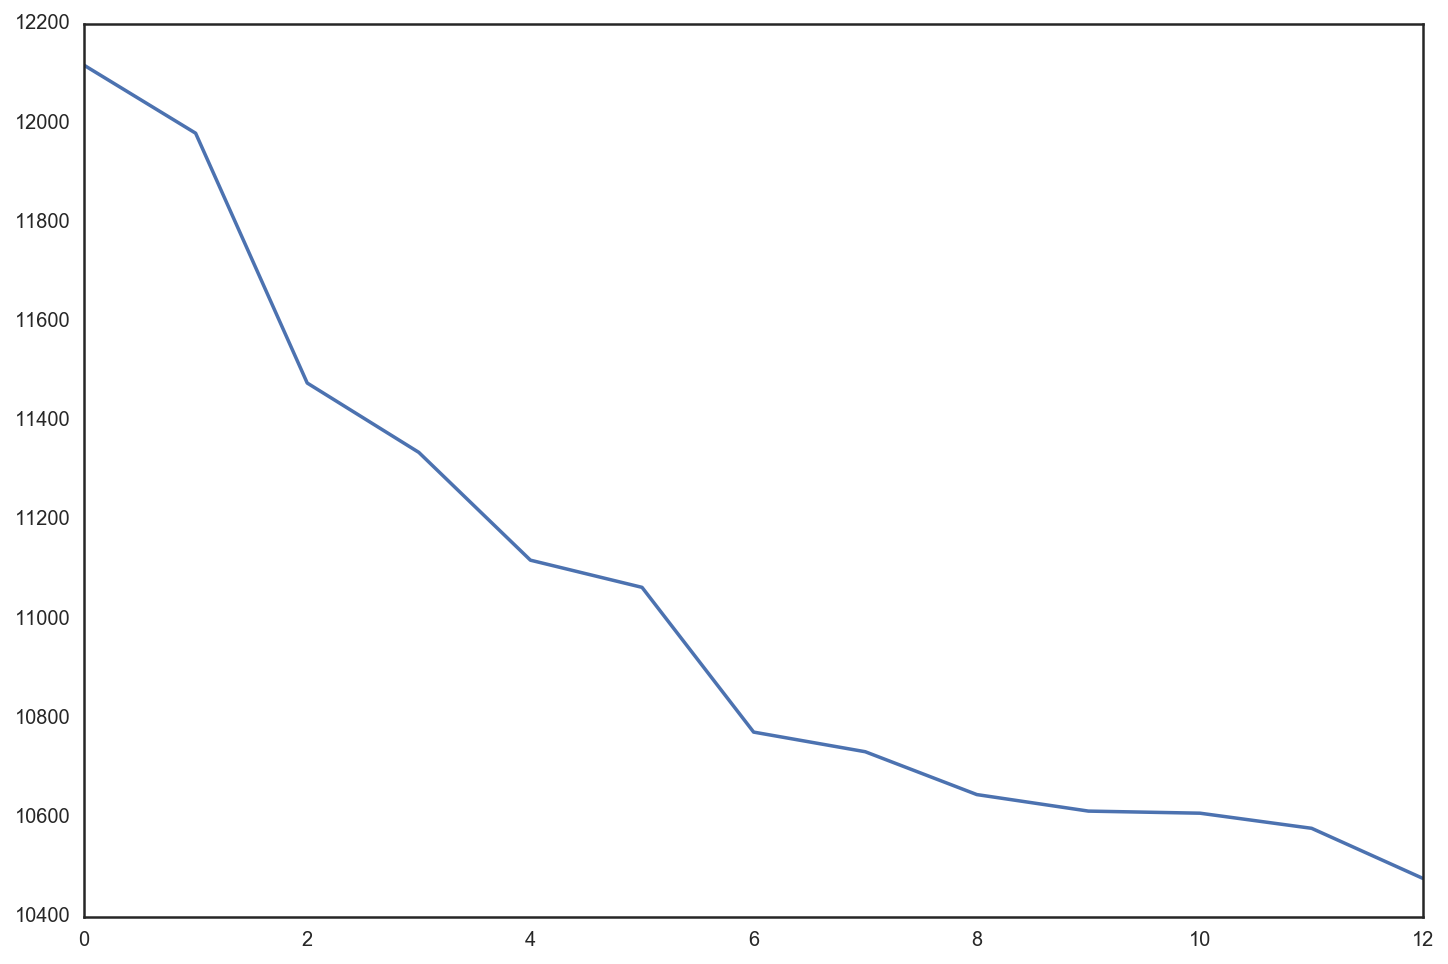

In [128]:
plt.plot(values[5:])

In [133]:
best= contents[bestI[-1]]

print "First Cluster\n============="
print best[0]['cov']
print
print best[0]['means']
print
print "Second Cluster\n=============="
print best[1]['cov']
print
print best[1]['means']
print
print "Third Cluster\n=============="
print best[2]['cov']
print
print best[2]['means']

First Cluster
[[  3.53275448e-02   4.36991543e-04   5.84674369e+02]
 [  4.36991543e-04   3.35563218e-02  -6.55483533e+02]
 [  5.84674369e+02  -6.55483533e+02   7.16512972e+09]]

[   -70.91708708     42.29394177  21721.41863817]

Second Cluster
[[  3.70943678e-02  -5.53609214e-05  -1.52407098e+02]
 [ -5.53609214e-05   3.44615075e-02   1.55380313e+01]
 [ -1.52407098e+02   1.55380313e+01   1.53055599e+08]]

[   -71.11234706     42.32629637  21527.8403379 ]

Third Cluster
[[  3.64879711e-02   5.93194922e-04   2.12345507e+02]
 [  5.93194922e-04   3.47438288e-02  -6.51877490e+02]
 [  2.12345507e+02  -6.51877490e+02   3.93018981e+08]]

[   -71.12273081     42.70683275  21734.94905245]


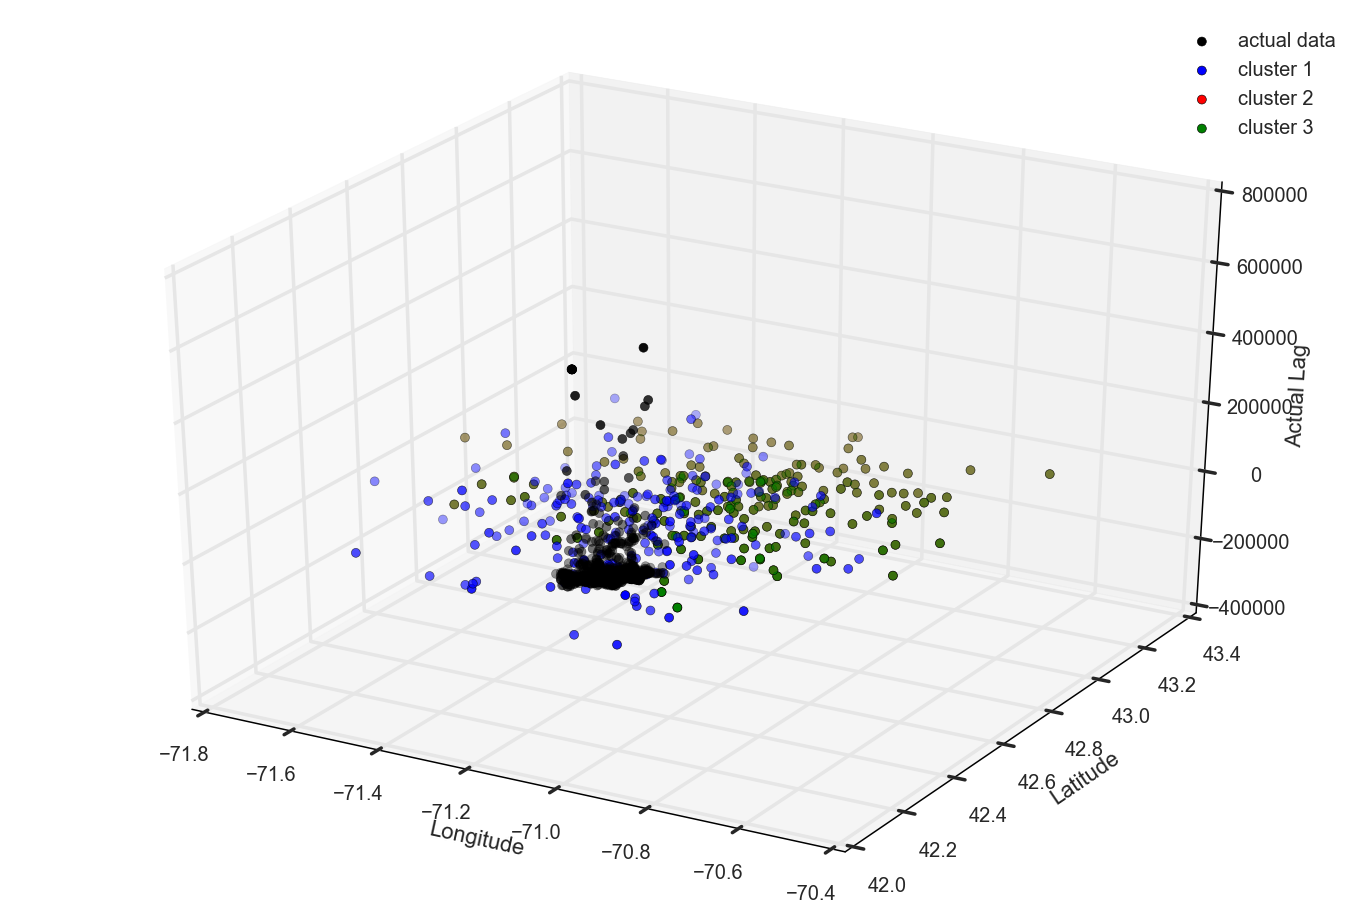

In [117]:
# select which dimensions to plot 
ds = (0,1,2)

best = contents[bestI[-1]]
norm1 = np.random.multivariate_normal(mean=best[0]['means'], cov=best[0]['cov'], size=200)
norm2 = np.random.multivariate_normal(mean=best[1]['means'], cov=best[1]['cov'], size=200)
norm2 = np.random.multivariate_normal(mean=best[2]['means'], cov=best[2]['cov'], size=200)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dat[:,ds[0]], dat[:,ds[1]], dat[:,ds[2]], c='k', label='actual data')
ax.scatter(norm1[:,ds[0]], norm1[:,ds[1]], norm1[:,ds[2]], c='b', label='cluster 1')
ax.scatter(norm2[:,ds[0]], norm2[:,ds[1]], norm2[:,ds[2]], c='r', label='cluster 2')
ax.scatter(norm2[:,ds[0]], norm2[:,ds[1]], norm2[:,ds[2]], c='g', label='cluster 3')
ax.set_xlabel(dims[ds[0]])
ax.set_ylabel(dims[ds[1]])
ax.set_zlabel(dims[ds[2]])
plt.legend()
plt.show()

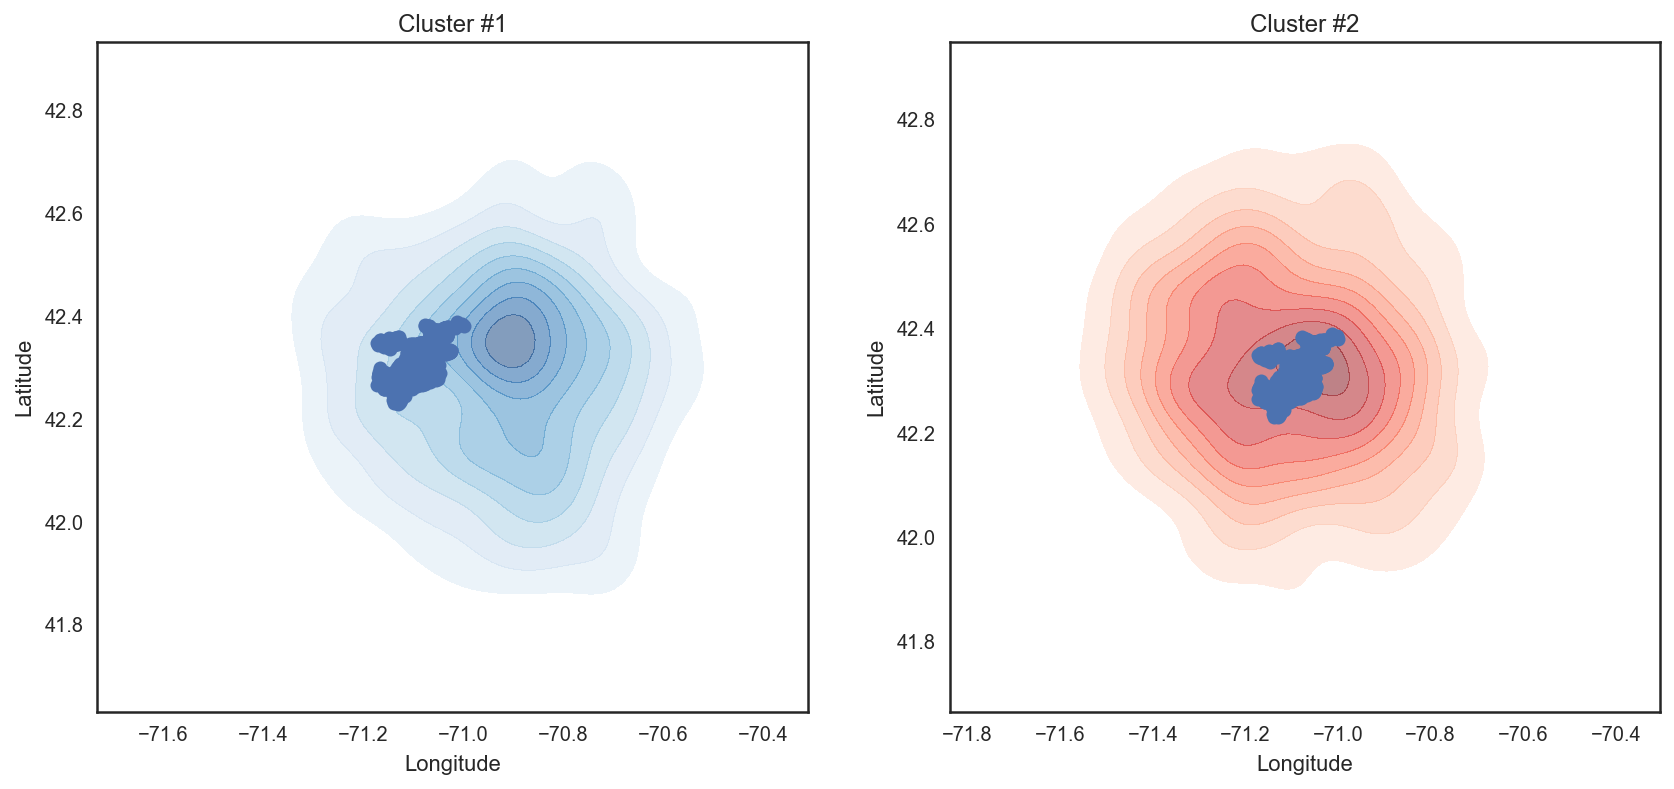

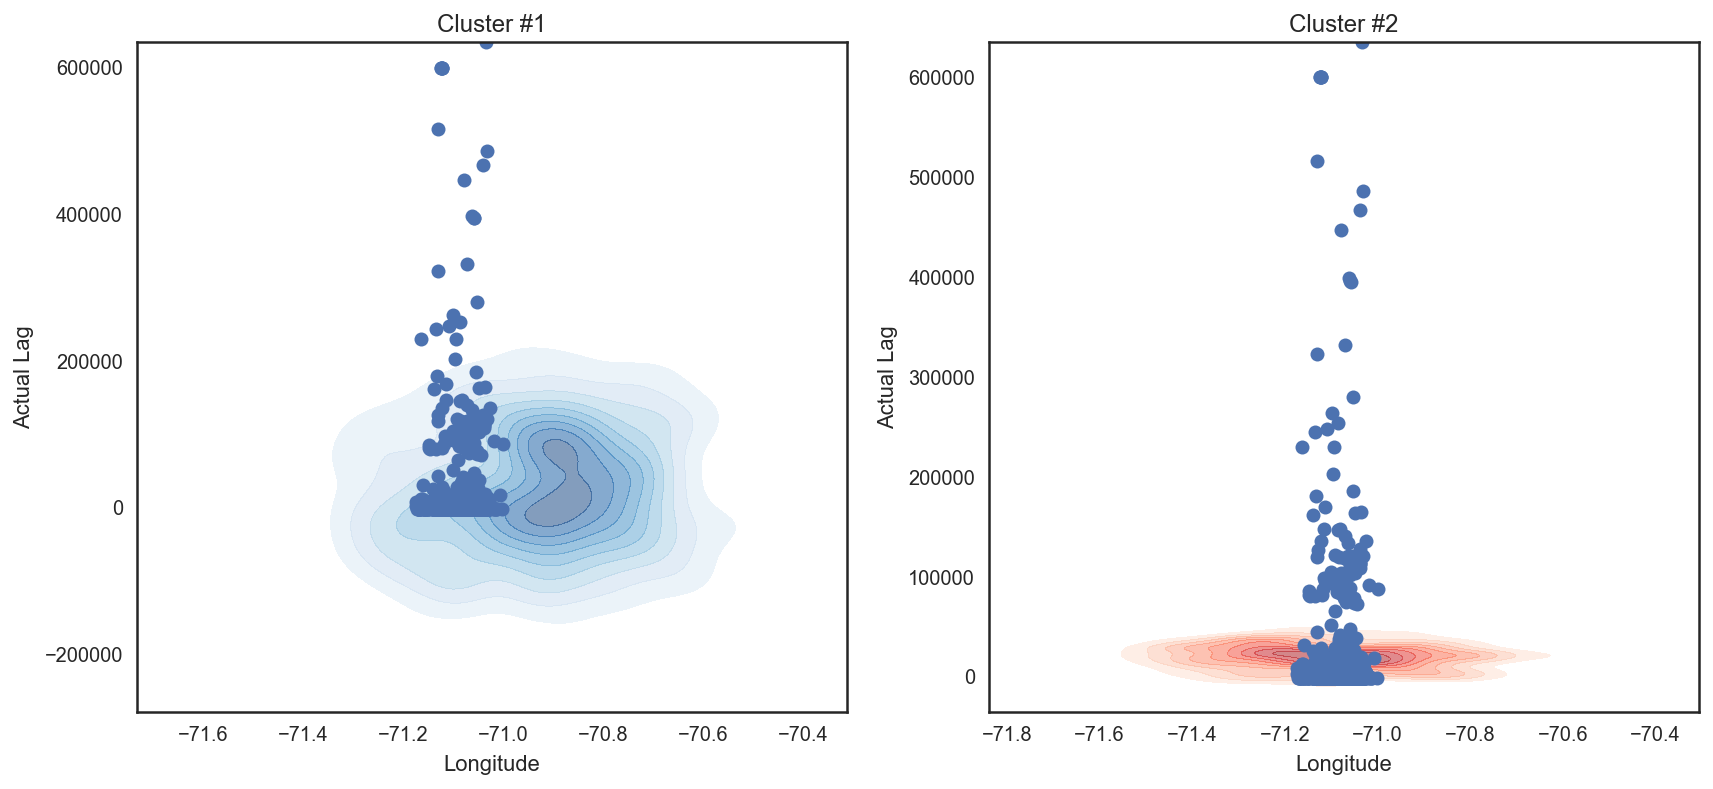

In [132]:
best = contents[bestI[-1]]
norm1 = np.random.multivariate_normal(mean=best[0]['means'], cov=best[0]['cov'], size=300)
norm2 = np.random.multivariate_normal(mean=best[1]['means'], cov=best[1]['cov'], size=300)

def display_2d_slices(ds=[0,1]):
    plt.figure(figsize=[14,6])
    plt.subplot(121)
    plt.title("Cluster #1")
    ax = sns.kdeplot(norm1[:,ds[0]], norm1[:,ds[1]],
                    cmap="Blues", shade=True, shade_lowest=False, alpha=.5)
    plt.plot(dat[:,ds[0]], dat[:,ds[1]], 'o')
    plt.xlabel(dims[ds[0]])
    plt.ylabel(dims[ds[1]])
    plt.subplot(122)
    plt.title("Cluster #2")
    ax = sns.kdeplot(norm2[:,ds[0]], norm2[:,ds[1]],
                     cmap="Reds", shade=True, shade_lowest=False, alpha=.5)
    plt.plot(dat[:,ds[0]], dat[:,ds[1]], 'o')
    plt.xlabel(dims[ds[0]])
    plt.ylabel(dims[ds[1]])

display_2d_slices()
display_2d_slices([0,2])

In [24]:
# %load anim.py
# useful code for handling animations--especially useful for our temporal data
# code taken from http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/
# requires having ffmeg installed on the computer
#    `homebrew install ffmpeg

from tempfile import NamedTemporaryFile
from IPython.display import HTML
from matplotlib import animation

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

animation.Animation._repr_html_ = anim_to_html


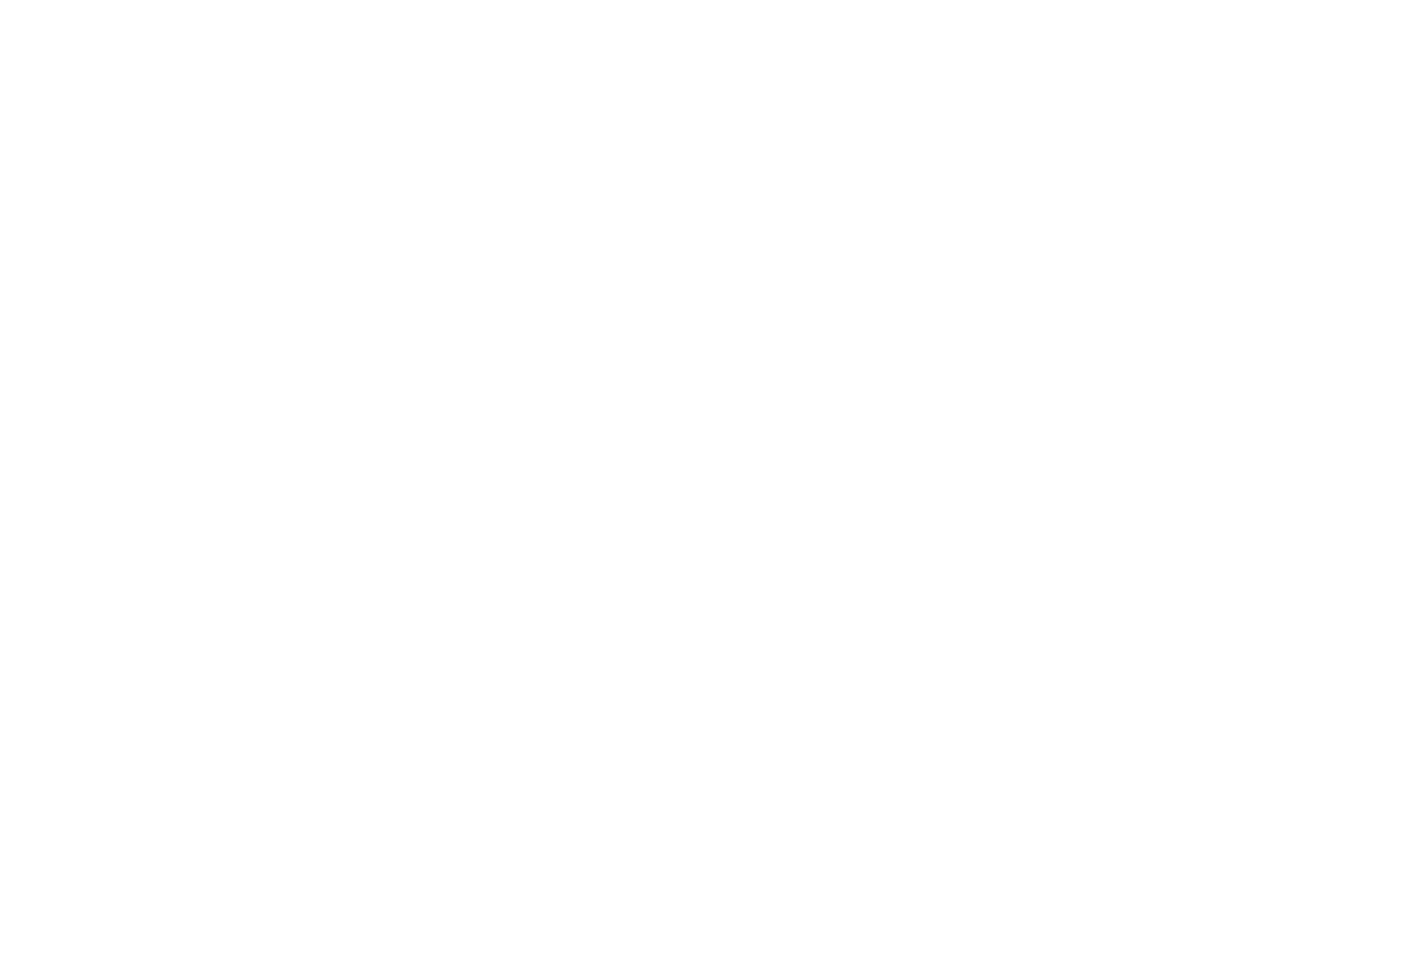

In [26]:
num = len(bestI)
best = contents[bestI[0]]
norm1 = np.random.multivariate_normal(mean=best[0]['means'], cov=best[0]['cov'], size=300)

fig = plt.figure()
ax = plt.subplot(111)
plt.title("Cluster 1 Over Time")

def init():
    ax = sns.kdeplot(norm1[:,ds[0]], norm1[:,ds[1]],
                     cmap="Blues", shade=True, shade_lowest=False, alpha=.5)
    return ax,

def animate(i):
    best = contents[bestI[i]]
    norm1 = np.random.multivariate_normal(mean=best[0]['means'], cov=best[0]['cov'], size=300)
    ax = sns.kdeplot(norm1[:,ds[0]], norm1[:,ds[1]],
                     cmap="Blues", shade=True, shade_lowest=False, alpha=.5)
    return ax,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=num, interval=50, blit=True)

display_animation(anim)

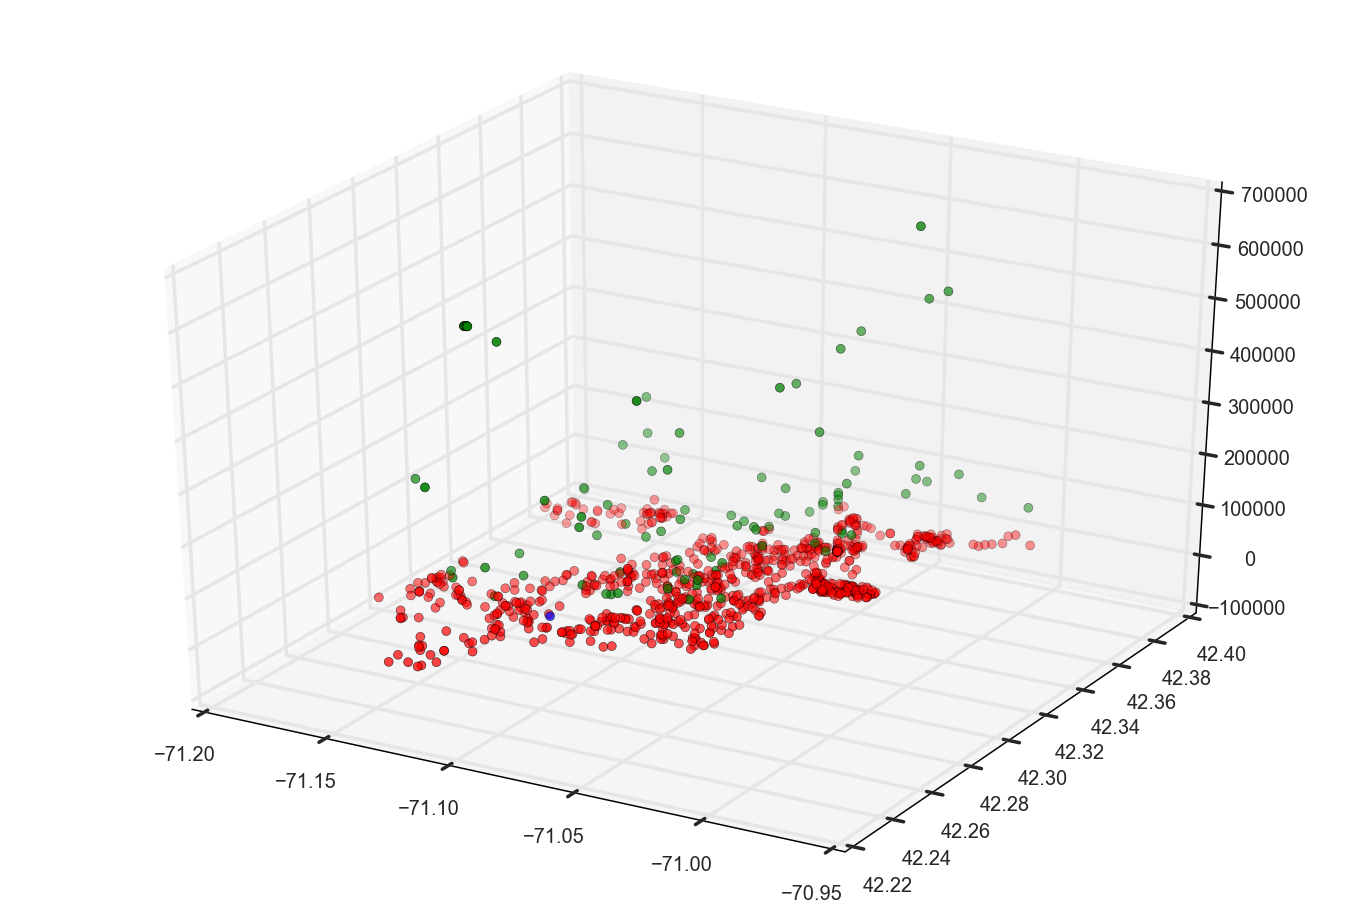

In [126]:
# hard clustering

def to_col(i):
    lst = ['g', 'r', 'b']
    return lst[i]

best = contents[bestI[-1]]
cols = [to_col(np.argmax(get_likl(row, best))) for row in dat]

#print dat[np.array(cols)==0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dat[:,0], dat[:,1], dat[:,2], c=cols)